STEPS WE WILL FOLLOW:
1. We will collect the stock data for AAPL
2. preprocess the data i.e. train and test split
3. Create a Stacked LSTM model
4. Predict the test data and plot the output
5. Predict the future 30 days and plot the output 

In [2]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data as pdr
import datetime as dt

In [3]:
#!pip install yfinance

In [4]:
import yfinance as yf

## STEP-1 Collect the stock data for AAPL

In [6]:
end = dt.datetime.now()
start = end - dt.timedelta(days=5000)
#start = dt.datetime(2015,1,1)
#start = dt.datetime(2000,1,1) #for getting all the data from 2000 onwards
start, end

(datetime.datetime(2011, 3, 18, 20, 31, 57, 167681),
 datetime.datetime(2024, 11, 24, 20, 31, 57, 167681))

In [7]:
stocklist = ['AAPL']
#stocks = [i + '.AX' for i in stocklist]
stocklist

['AAPL']

In [8]:
#df = pdr.get_data_yahoo(stocks, start, end)

In [9]:
#pdr.DataReader(stocks,'yahoo',start,end)

In [10]:
df = yf.download(stocklist, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [11]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2011-03-21,10.221982,12.117857,12.133571,11.973571,11.999643,409402000
2011-03-22,10.279226,12.185714,12.236429,12.112143,12.234286,325922800
2011-03-23,10.218669,12.113929,12.150714,11.998214,12.117143,372996400
2011-03-24,10.392801,12.320357,12.357143,12.102143,12.208929,404712000
2011-03-25,10.590738,12.555000,12.573571,12.393571,12.431071,448910000


In [12]:
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2024-11-18,228.020004,228.020004,229.740005,225.169998,225.250000,44686000
2024-11-19,228.279999,228.279999,230.160004,226.660004,226.979996,36211800
2024-11-20,229.000000,229.000000,229.929993,225.889999,228.059998,35169600
2024-11-21,228.520004,228.520004,230.160004,225.710007,228.880005,42108300
2024-11-22,229.869995,229.869995,230.720001,228.059998,228.059998,38153300


In [13]:
df.to_csv('AAPL.csv')

In [14]:
df1 = df.reset_index()['Close']

In [15]:
df1

Ticker,AAPL
0,12.117857
1,12.185714
2,12.113929
3,12.320357
4,12.555000
...,...
3439,228.020004
3440,228.279999
3441,229.000000
3442,228.520004


In [16]:
df1.shape

(3444, 1)

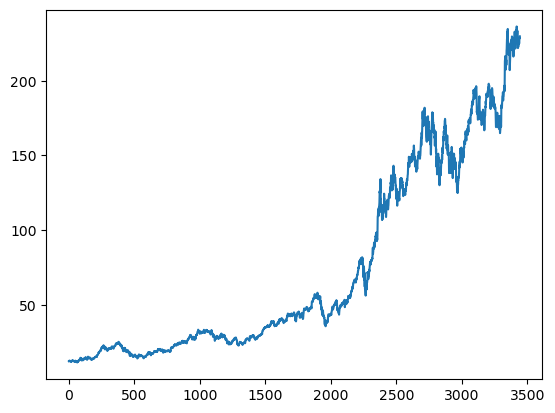

In [17]:
import matplotlib.pyplot as plt
plt.plot(df1)

## STEP-2 Preprocessing the data i.e. train and test split

In [19]:
## LSTM are sensitive to the scale of the data, so we applt MinMax Scaler

In [20]:
import numpy as np

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [22]:
df1

array([[0.00380265],
       [0.00410395],
       [0.00378521],
       ...,
       [0.96678784],
       [0.96465659],
       [0.97065073]])

In [23]:
df1.shape

(3444, 1)

In [24]:
## Splitting the dataset into train and test split
## Be aware that the dataset should not be split randomly in the time series dataset as one day's data depends on the previous day's data.
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1), :1]

In [25]:
training_size, test_size

(2238, 1206)

In [26]:
train_data

array([[0.00380265],
       [0.00410395],
       [0.00378521],
       ...,
       [0.31099154],
       [0.30524158],
       [0.30692882]])

What we did for the X_train and y_train is that we have taken any number of values(let's say 5), we take the first 4 values(1,2,3,4) as our X_train and the 5th value as y_train. In the next time step, we have shifted this window by one, and now the X_train contains 2,3,4,5 and the 6th value goes into y_train, and so on...

This method is similarly repeated for X_test and y_test

Here for this dataset, we have taken the time step value of 100, so the first 99 values is X_train and 100th value is y_train

In [28]:
## Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]     ###i=0,  0,1,2,3---99   100
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
## reshape into X=t, t+1, t+2, t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [30]:
print(X_train)

[[0.00380265 0.00410395 0.00378521 ... 0.00600845 0.00930683 0.00767033]
 [0.00410395 0.00378521 0.00470178 ... 0.00930683 0.00767033 0.00925767]
 [0.00378521 0.00470178 0.00574363 ... 0.00767033 0.00925767 0.00977939]
 ...
 [0.19763499 0.19281746 0.19409399 ... 0.29356405 0.29262051 0.30393175]
 [0.19281746 0.19409399 0.19498202 ... 0.29262051 0.30393175 0.30681784]
 [0.19409399 0.19498202 0.19727979 ... 0.30393175 0.30681784 0.31099154]]


In [31]:
print(X_train.shape)
print(y_train.shape)

(2137, 100)
(2137,)


In [32]:
print(X_test.shape)
print(y_test.shape)

(1105, 100)
(1105,)


# STEP-3 Create a Stacked LSTM model

### reshape input to be (samples, time_steps, features) which is required for LSTM

In [35]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Stack LSTM means one LSTM layer over other OR multiple LSTM models stacked 

In [37]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

input_shape in lstm is always the last two values of the X_train, here it is time_step and features(i.e. (100,1))

In [39]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 8.4859e-05 - val_loss: 0.0014
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 5.3383e-05 - val_loss: 0.0028
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 5.7810e-05 - val_loss: 0.0034
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 5.1024e-05 - val_loss: 0.0031
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 5.1044e-05 - val_loss: 0.0039
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 4.6209e-05 - val_loss: 0.0032
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 4.1757e-05 - val_loss: 0.0026
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 4.3390e-05 - val_loss: 0.0016
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 4.2450e-05 - val_loss: 0.0022
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 4.0506e-05 - val_loss: 0.0014
Ep

## STEP-4 Predict the test data and plot the output`

In [43]:
train_predict=model.predict(X_train)
test_predict = model.predict(X_test)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [44]:
## Transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [45]:
### Calculate RMSE performance metrics 
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

34.89355965414881

In [46]:
## Test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

164.8968440892929

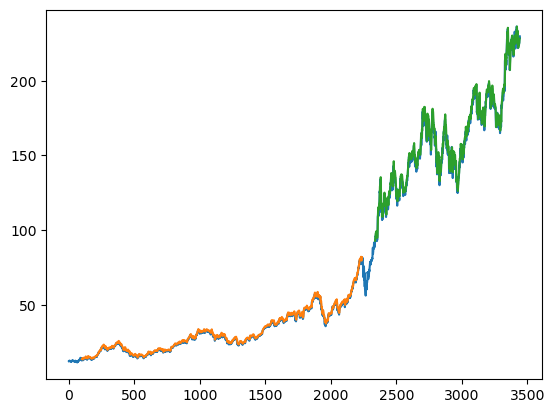

In [47]:
### Plotting 
# shift the train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


### Green = predicted output
### Orange = training set
### Blue = overall dataset

## STEP-5 Predict the future 30 days and plot the output

In [91]:
len(test_data)

1206

In [95]:
X_input = test_data[1106:].reshape(1,-1)
X_input.shape

(1, 100)

In [97]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [107]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input=X_input.reshape(1,-1)
        X_input = X_input.reshape((1, n_steps, 1))
        #print(X_input)
        yhat = model.predict(X_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        X_input = X_input.reshape((1, n_steps,1))
        yhat = model.predict(X_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.96830696]
101
1 day input [0.96154851 0.96536696 0.98445954 0.96043848 0.97362561 0.99076452
 0.99262943 0.96625504 0.94538637 0.94596361 0.94440961 0.94907169
 0.92034403 0.91568195 0.91776882 0.91901205 0.92149851 0.93606214
 0.91954484 0.92620504 0.87918407 0.87012616 0.88162615 0.89712217
 0.91013179 0.91585953 0.93246564 0.93446369 0.94778408 0.95368946
 0.95297903 0.95573189 0.95524347 0.94694044 0.95719714 0.95870677
 0.9624809  0.95564313 0.97029551 0.96678784 0.93912584 0.93060079
 0.93739419 0.9304676  0.93086719 0.92731507 0.93863742 0.93912584
 0.93792698 0.91048701 0.9125738  0.92989036 0.9662106  0.96323572
 0.95555431 0.9595504  0.95511027 0.96021646 0.96141525 0.98454836
 0.9543999  0.95693074 0.95200219 0.95701956 0.93433049 0.95244623
 0.96918548 0.96696541 0.96034966 0.97700015 0.9883225  0.9791314
 0.98077422 0.99342862 1.         0.99724714 0.97460244 0.97375888
 0.97748857 0.98632439 0.98752324 0.97167201 0.95306785 0.93974745
 0.9357513  0.9421451  0.93890382 

In [109]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [111]:
len(df1)

3444

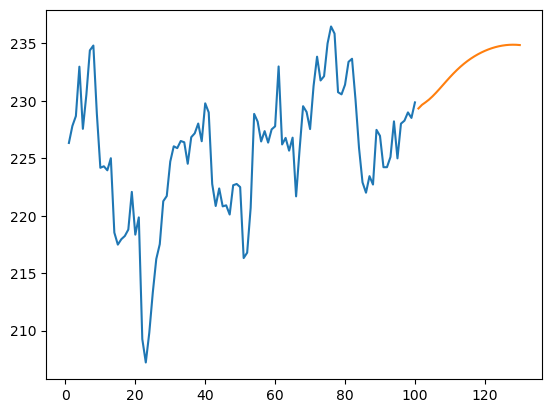

In [113]:
plt.plot(day_new,scaler.inverse_transform(df1[3344:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

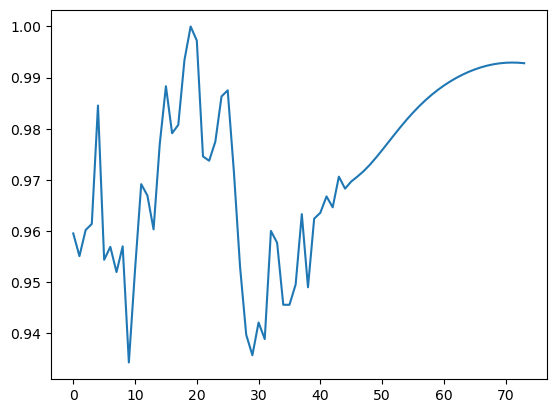

In [115]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[3400:])

In [117]:
df3=scaler.inverse_transform(df3).tolist()

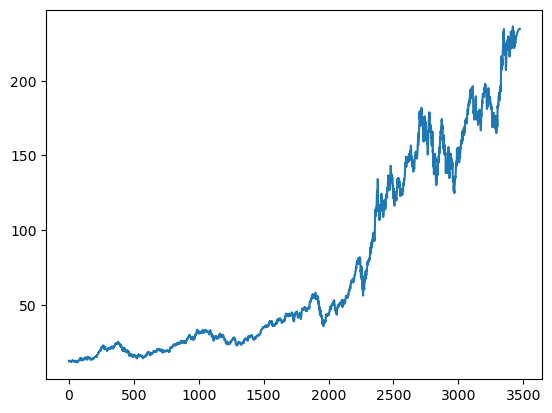

In [119]:
plt.plot(df3)